In [2]:
import os
os.chdir('/Users/jlo/Desktop/LHL/LHLProjects/LHL-Capstone-Project')

In [137]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import pickle
import joblib
import shap
from sklearn.model_selection import train_test_split
from src.data_preprocessing import df_construct, add_eng_values, alter_term_gender
from src.model_training import build_preprocessor, build_full_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier

In [3]:
excel_file = pd.ExcelFile('data/raw_data/D2lData.xlsx')

# Reading each sheet into a DataFrame
df_d2l = pd.read_excel(excel_file, 'd2l')
df_demo = pd.read_excel(excel_file, 'demographics')
df_grades = pd.read_excel(excel_file, 'grades')

# Section 1: General EDA - Stats, Distributions, Outliers, Duplicates, Nulls, Multicolinearity

In [68]:
df_d2l.head()

content_completed  content_required  checklist_completed  \
4829                 45               239                    0   
4830                 80               239                    1   
4828                 42               239                    0   
476                 181               233                    0   
470                 151               233                    0   

      quiz_completed  total_quiz_attempts  discussion_post_created  \
4829               3                    3                        0   
4830               4                    4                        1   
4828               3                    3                        0   
476               25                   33                        0   
470               20                   34                        0   

      discussion_post_replies  discussion_post_read  \
4829                        0                     0   
4830                        0                     0   
4828                        0                     0   
476                         0                     0   
470                         0                     0   

         last_discussion_post_date  number_of_assignment_submissions  ...  \
4829                           NaN                                 2  ...   
4830  2022-09-30T16:57:37.1170000Z                                 2  ...   
4828                           NaN                                 1  ...   
476                            NaN                                 3  ...   
470                            NaN                                11  ...   

     total_time_spent_in_content             last_visited_date  \
4829                       18155  2023-01-17T19:54:22.8600000Z   
4830                        5359  2023-08-17T21:42:18.9100000Z   
4828                       14453  2023-06-02T01:31:13.0030000Z   
476                        87524  2023-02-01T17:34:13.2030000Z   
470                        86277  2022-12-29T05:18:48.2070000Z   

                 last_system_login number_of_logins_to_the_system  \
4829  2023-11-09T17:04:56.3730000Z                           4083   
4830  2023-09-30T20:04:55.0830000Z                            631   
4828  2023-11-13T18:32:29.6130000Z                           1839   
476   2023-11-15T16:43:16.0600000Z                            439   
470   2023-11-16T21:00:51.6070000Z                            626   

            last_quiz_attempt_date   term pseudo_id  pseudo_course  \
4829  2022-12-09T16:51:05.9100000Z  2022F       237     course_244   
4830  2022-12-09T15:20:47.7170000Z  2022F      1150     course_244   
4828  2022-12-13T01:55:06.2900000Z  2022F        88     course_244   
476   2022-11-24T19:56:58.1300000Z  2022F       559      course_85   
470   2022-12-01T16:14:45.4530000Z  2022F        22      course_85   

     grade_value  completion_ratio  
4829         3.5          0.188285  
4830         3.5          0.334728  
4828         3.7          0.175732  
476          0.0          0.776824  
470          1.0          0.648069  

[5 rows x 21 columns]

In [6]:
df_demo.head()

gender imm_status           city postal_code  age  pseudo_student_id
0      M   domestic        Corunna         N0N   45                  0
1      F   domestic  Brights Grove         N0N   38                  1
2      F   domestic         Sarnia         N7V   40                  2
3      F   domestic    Wallaceburg         N8A   41                  3
4      F   domestic         Sarnia         N7V   39                  4

In [7]:
df_grades.head()

term grade  grade_value pseudo_course_name  pseudo_student_id
0  2023W     B          3.0           course_0                  0
1  2022F     B          3.0           course_1                  0
2  2022F     A          3.7           course_2                  0
3  2023W     C          2.0           course_3                  0
4  2023W    A-          3.5           course_4                  0

## Basic Stats of our D2L data

In [8]:
df_d2l.describe()

content_completed  content_required  checklist_completed  \
count        7264.000000       7264.000000          7264.000000   
mean           25.234857         52.453056             0.022026   
std            22.394549         36.166728             0.435654   
min             0.000000          0.000000             0.000000   
25%             8.000000         28.000000             0.000000   
50%            22.000000         45.000000             0.000000   
75%            36.000000         67.000000             0.000000   
max           184.000000        239.000000            12.000000   

       quiz_completed  total_quiz_attempts  discussion_post_created  \
count     7264.000000          7264.000000              7264.000000   
mean         3.375413             5.421393                 0.192869   
std          4.666183            13.723370                 0.818920   
min          0.000000             0.000000                 0.000000   
25%          0.000000             0.000000                 0.000000   
50%          2.000000             2.000000                 0.000000   
75%          4.000000             5.000000                 0.000000   
max         39.000000           344.000000                17.000000   

       discussion_post_replies  discussion_post_read  \
count              7264.000000           7264.000000   
mean                  0.268860              2.020512   
std                   1.882034             12.735167   
min                   0.000000              0.000000   
25%                   0.000000              0.000000   
50%                   0.000000              0.000000   
75%                   0.000000              0.000000   
max                  35.000000            355.000000   

       number_of_assignment_submissions  total_time_spent_in_content  \
count                       7264.000000                  7264.000000   
mean                           3.903772                 11266.975633   
std                            5.070992                 18234.700244   
min                            0.000000                     0.000000   
25%                            0.000000                   716.000000   
50%                            2.000000                  4768.500000   
75%                            7.000000                 14075.250000   
max                           34.000000                242230.000000   

       number_of_logins_to_the_system    pseudo_id  
count                     7264.000000  7264.000000  
mean                      1040.710077   617.301349  
std                        773.869912   340.634759  
min                          0.000000     0.000000  
25%                        594.000000   327.750000  
50%                        827.000000   633.000000  
75%                       1225.000000   909.000000  
max                       6246.000000  1244.000000

In [9]:
df_d2l['pseudo_course'].nunique()

227

### Create a grade_value column in df_d2l, filling with grade_value from df_grades based on student id, course id, and term.

In [14]:
# appending the "grade_value" column into the df_d2l dataframe

df_d2l['grade_value'] = df_d2l.apply(lambda row: df_grades[
    (df_grades['pseudo_student_id'] == row['pseudo_id']) & 
    (df_grades['pseudo_course_name'] == row['pseudo_course']) &
        (df_grades['term'] == row['term'])
]['grade_value'].values[0] if not df_grades[
    (df_grades['pseudo_student_id'] == row['pseudo_id']) & 
    (df_grades['pseudo_course_name'] == row['pseudo_course']) &
        (df_grades['term'] == row['term'])
].empty else None, axis=1)

In [15]:
df_d2l.head()

content_completed  content_required  checklist_completed  quiz_completed  \
0                 33                45                    0               0   
1                 29                45                    0               0   
2                 18                45                    0               0   
3                 41                45                    0               0   
4                 26                45                    0               0   

   total_quiz_attempts  discussion_post_created  discussion_post_replies  \
0                    0                        0                        0   
1                    0                        0                        0   
2                    0                        0                        0   
3                    0                        0                        0   
4                    0                        0                        0   

   discussion_post_read last_discussion_post_date  \
0                     0                       NaN   
1                     0                       NaN   
2                     0                       NaN   
3                     0                       NaN   
4                     0                       NaN   

   number_of_assignment_submissions last_assignment_submission_date  \
0                                13    2022-12-13T05:06:45.2200000Z   
1                                 7    2022-12-17T00:21:34.3630000Z   
2                                16    2022-12-15T04:48:22.4530000Z   
3                                12    2022-12-15T04:52:37.5670000Z   
4                                15    2022-12-15T06:52:24.3670000Z   

   total_time_spent_in_content             last_visited_date  \
0                         2018  2023-01-28T16:08:51.4230000Z   
1                         5181  2022-12-17T00:21:52.5200000Z   
2                         1254  2022-12-30T22:49:53.2530000Z   
3                         2547  2023-08-27T21:41:20.2700000Z   
4                         5868  2022-12-21T02:13:30.7470000Z   

              last_system_login  number_of_logins_to_the_system  \
0  2023-04-28T15:00:47.2000000Z                            2944   
1  2023-06-20T18:42:01.1430000Z                            1357   
2  2023-09-19T04:56:12.9870000Z                            1084   
3  2023-11-15T21:51:38.5800000Z                             879   
4  2023-11-17T15:01:55.5000000Z                            2362   

  last_quiz_attempt_date   term  pseudo_id pseudo_course  grade_value  
0                    NaN  2022F         86    course_221          4.0  
1                    NaN  2022F        248    course_221          4.0  
2                    NaN  2022F        141    course_221          4.0  
3                    NaN  2022F        330    course_221          3.7  
4                    NaN  2022F         76    course_221          4.0

### Check for null values and shapes of our df_d2l and df_grades dataframes

In [16]:
df_d2l.isna().sum()

content_completed                      0
content_required                       0
checklist_completed                    0
quiz_completed                         0
total_quiz_attempts                    0
discussion_post_created                0
discussion_post_replies                0
discussion_post_read                   0
last_discussion_post_date           6481
number_of_assignment_submissions       0
last_assignment_submission_date     2715
total_time_spent_in_content            0
last_visited_date                    660
last_system_login                     23
number_of_logins_to_the_system         0
last_quiz_attempt_date              2946
term                                   0
pseudo_id                              0
pseudo_course                          0
grade_value                          108
dtype: int64

In [17]:
df_d2l.shape

(7264, 20)

In [18]:
df_grades.shape

(13249, 5)

### Checking for outliers in df_d2l

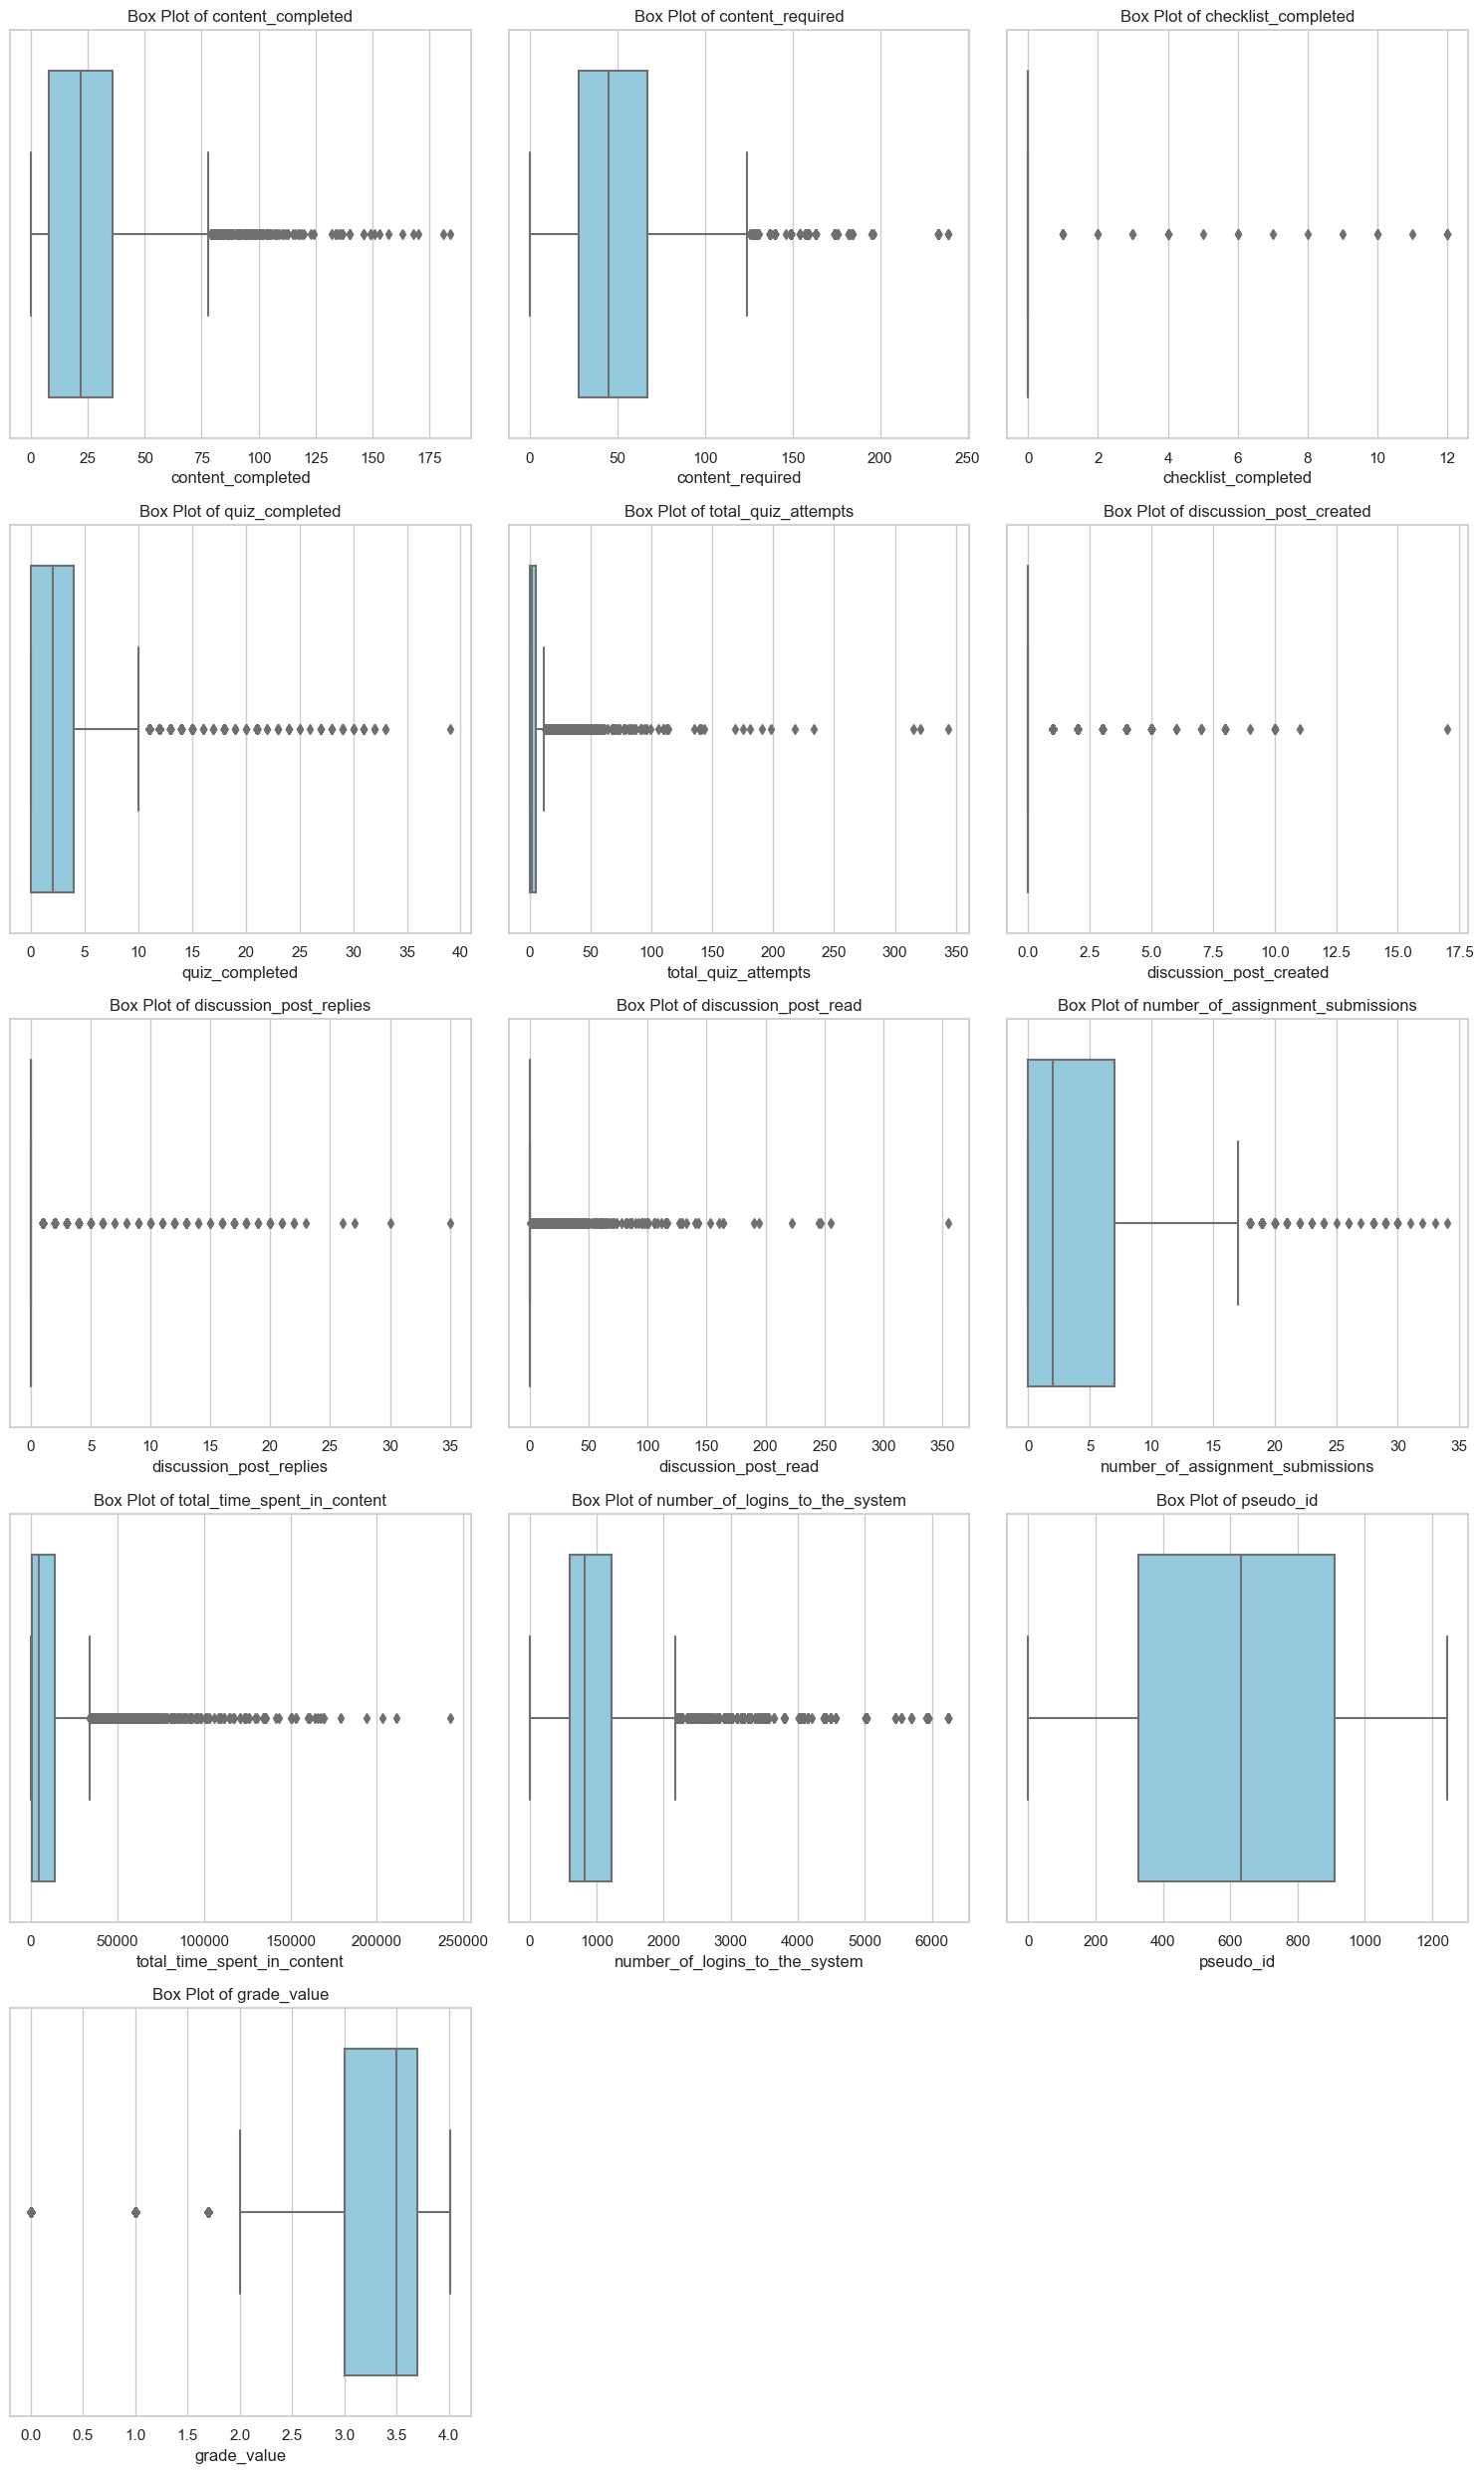

In [24]:
sns.set(style="whitegrid")

# Get the list of numeric columns
numeric_columns = df_d2l.select_dtypes(include='number').columns

# Calculate the number of rows needed for the grid layout
num_cols = 3
num_rows = math.ceil(len(numeric_columns) / num_cols)

# Create a grid layout for subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Flatten the axes array to make it easier to iterate
axes = axes.flatten()

# Plot individual box plots for each numeric column
for i, column in enumerate(numeric_columns):
    sns.boxplot(x=df_d2l[column], color='skyblue', ax=axes[i])
    axes[i].set_title(f'Box Plot of {column}')
    axes[i].set_xlabel(column)

# Hide any unused subplots
for j in range(len(numeric_columns), num_cols * num_rows):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

#### There are many outliers in this data set, mainly because many of the measured values have values of zero or close to zero.  Nonetheless, we will need to mitigate the effects of these outliers when model building.

### Adding a column called "completion_ratio" to our df_d2l that compares the completed content to the required content.

In [25]:
df_d2l['completion_ratio'] = df_d2l['content_completed']/df_d2l['content_required']

In [26]:
df_d2l.head()

content_completed  content_required  checklist_completed  quiz_completed  \
0                 33                45                    0               0   
1                 29                45                    0               0   
2                 18                45                    0               0   
3                 41                45                    0               0   
4                 26                45                    0               0   

   total_quiz_attempts  discussion_post_created  discussion_post_replies  \
0                    0                        0                        0   
1                    0                        0                        0   
2                    0                        0                        0   
3                    0                        0                        0   
4                    0                        0                        0   

   discussion_post_read last_discussion_post_date  \
0                     0                       NaN   
1                     0                       NaN   
2                     0                       NaN   
3                     0                       NaN   
4                     0                       NaN   

   number_of_assignment_submissions  ... total_time_spent_in_content  \
0                                13  ...                        2018   
1                                 7  ...                        5181   
2                                16  ...                        1254   
3                                12  ...                        2547   
4                                15  ...                        5868   

              last_visited_date             last_system_login  \
0  2023-01-28T16:08:51.4230000Z  2023-04-28T15:00:47.2000000Z   
1  2022-12-17T00:21:52.5200000Z  2023-06-20T18:42:01.1430000Z   
2  2022-12-30T22:49:53.2530000Z  2023-09-19T04:56:12.9870000Z   
3  2023-08-27T21:41:20.2700000Z  2023-11-15T21:51:38.5800000Z   
4  2022-12-21T02:13:30.7470000Z  2023-11-17T15:01:55.5000000Z   

  number_of_logins_to_the_system  last_quiz_attempt_date   term pseudo_id  \
0                           2944                     NaN  2022F        86   
1                           1357                     NaN  2022F       248   
2                           1084                     NaN  2022F       141   
3                            879                     NaN  2022F       330   
4                           2362                     NaN  2022F        76   

   pseudo_course grade_value  completion_ratio  
0     course_221         4.0          0.733333  
1     course_221         4.0          0.644444  
2     course_221         4.0          0.400000  
3     course_221         3.7          0.911111  
4     course_221         4.0          0.577778  

[5 rows x 21 columns]

### Let's check the distributions of our numerical columns in df_d2l

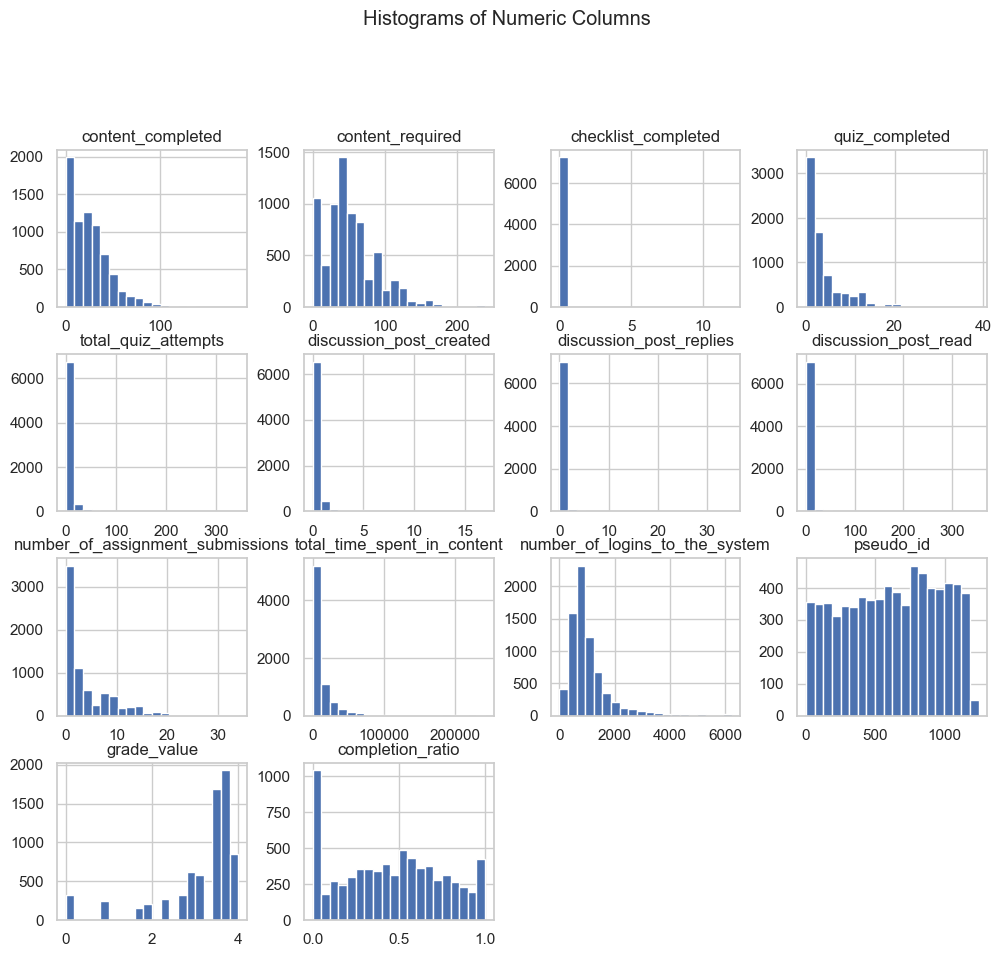

In [27]:
#Checking distributions of numerical columns

# Plot histograms for all numeric columns
df_d2l.hist(figsize=(12, 10), bins=20)
plt.suptitle('Histograms of Numeric Columns', y=1.02)
plt.show()

#### We can see that most of these graphs are skewed.  When training our models, we will consider scaling our feature values with a log transformer or box-cox method.

### Let's check to see how many rows (courses) don't include content in the d2l shells, and what their grade spreads are.

In [28]:
# listing all of the courses with no content required
courses_w_no_content=list(df_d2l.loc[df_d2l['content_required']==0, 'pseudo_course'].unique())

In [40]:
# listing the grade values for courses with no content required
grades_no_content = list(df_d2l.loc[df_d2l['content_required']==0, 'grade_value'].unique())

In [44]:
print(sorted(grades_no_content))

[0.0, 1.0, 1.7, 2.0, 2.3, 2.7, 3.0, 3.2, 3.5, 3.7, 4.0]


#### It appears that there are courses that do not require students to have to interact with any course content, while students can still earn any letter grade from F all the way to an A+
- We will keep this in mind when training the model and include the course id into the training

### Checking to see what the rows of a unique student with multiple courses would look like.

In [46]:
df_d2l.groupby('pseudo_id').count().sort_values(by='content_completed')

content_completed  content_required  checklist_completed  \
pseudo_id                                                             
457                        1                 1                    1   
340                        1                 1                    1   
343                        1                 1                    1   
532                        1                 1                    1   
308                        1                 1                    1   
...                      ...               ...                  ...   
766                       22                22                   22   
162                       22                22                   22   
1136                      22                22                   22   
1144                      22                22                   22   
269                       22                22                   22   

           quiz_completed  total_quiz_attempts  discussion_post_created  \
pseudo_id                                                                 
457                     1                    1                        1   
340                     1                    1                        1   
343                     1                    1                        1   
532                     1                    1                        1   
308                     1                    1                        1   
...                   ...                  ...                      ...   
766                    22                   22                       22   
162                    22                   22                       22   
1136                   22                   22                       22   
1144                   22                   22                       22   
269                    22                   22                       22   

           discussion_post_replies  discussion_post_read  \
pseudo_id                                                  
457                              1                     1   
340                              1                     1   
343                              1                     1   
532                              1                     1   
308                              1                     1   
...                            ...                   ...   
766                             22                    22   
162                             22                    22   
1136                            22                    22   
1144                            22                    22   
269                             22                    22   

           last_discussion_post_date  number_of_assignment_submissions  \
pseudo_id                                                                
457                                0                                 1   
340                                0                                 1   
343                                0                                 1   
532                                0                                 1   
308                                0                                 1   
...                              ...                               ...   
766                                0                                22   
162                                0                                22   
1136                               0                                22   
1144                               0                                22   
269                                0                                22   

           last_assignment_submission_date  total_time_spent_in_content  \
pseudo_id                                                                 
457                                      1                            1   
340                                      1                            1   
343                                      1                         

- We can see that some students have up to 22 entries.  This may be of concern since this data covers only about 3 terms of time, and students would not typically have 22 courses over a span of that time.  Let's look into one of these students with 22 entries to see if there are duplicate rows.  Let's look at student id = 269

In [47]:
#Chose this one since it has 22 entries.
df_d2l[df_d2l['pseudo_id']==269]

content_completed  content_required  checklist_completed  \
2637                 54                63                    0   
2660                  0                 9                    0   
2697                 89               115                    0   
2720                  0                 9                    0   
2737                  0                 9                    0   
2786                 77               110                    0   
2817                 40                50                    0   
2846                 79               106                    0   
2869                  0                 9                    0   
2886                  0                 9                    0   
6341                 21                35                    0   
6362                 35                35                    0   
6810                  0                 8                    0   
6835                  0                 8                    0   
6861                  0                 8                    0   
6887                  0                 8                    0   
6913                  0                 8                    0   
7144                  0                 9                    0   
7169                  0                 9                    0   
7193                  0                 9                    0   
7218                  0                 9                    0   
7252                  0                 9                    0   

      quiz_completed  total_quiz_attempts  discussion_post_created  \
2637               3                    3                        0   
2660               0                    0                        0   
2697               3                    3                        0   
2720               0                    0                        0   
2737               0                    0                        0   
2786               3                    3                        0   
2817               3                    3                        0   
2846               3                    3                        0   
2869               0                    0                        0   
2886               0                    0                        0   
6341               1                    1                        0   
6362               2                    2                        0   
6810               0                    0                        0   
6835               0                    0                        0   
6861               0                    0                        0   
6887               0                    0                        0   
6913               0                    0                        0   
7144               0                    0                        0   
7169               0                    0                        0   
7193               0                    0                        0   
7218               0                    0                        0   
7252               0                    0                        0   

      discussion_post_replies  discussion_post_read last_discussion_post_date  \
2637                        0                     0                       NaN   
2660                        0                     0                       NaN   
2697                        0                     0                       NaN   
2720                        0                     0                       NaN   
2737                        0                     0                       NaN   
2786                        0                     0                       NaN   
2817                        0                     0                       NaN   
2846                        0                     0                       NaN   
2869                        0                     0                       NaN   
2886                        0                     0               

#### There were multiple entries that had the same pseudo_id, pseudo_course, grade_value, and term.  This shouldn't be possible since a student can only be taking any given course once a term. We've removed any entries such as this below, deciding to keep the entry with the highest value for "content_required"

In [48]:
# Sort the DataFrame by 'content_required' in descending order
df_d2l.sort_values(by='content_required', ascending=False, inplace=True)

# Drop duplicates based on the specified columns, keeping the first occurrence (which has the largest 'content_required')
df_d2l.drop_duplicates(subset=['pseudo_id', 'pseudo_course', 'grade_value', 'term'], keep='first', inplace=True)

In [49]:
df_d2l.shape

(6987, 21)

#### Let's re-check our student with id 269 to make sure this method works.  If so, we will apply it to our data before training a model to ensure these duplicate/erroneous rows will not negatively affect our model

In [50]:
df_d2l[df_d2l['pseudo_id']==269]

content_completed  content_required  checklist_completed  \
2697                 89               115                    0   
2786                 77               110                    0   
2846                 79               106                    0   
2637                 54                63                    0   
2817                 40                50                    0   
6341                 21                35                    0   
6362                 35                35                    0   
7193                  0                 9                    0   
7218                  0                 9                    0   
7169                  0                 9                    0   
7144                  0                 9                    0   
7252                  0                 9                    0   
6810                  0                 8                    0   
6835                  0                 8                    0   
6887                  0                 8                    0   
6913                  0                 8                    0   
6861                  0                 8                    0   

      quiz_completed  total_quiz_attempts  discussion_post_created  \
2697               3                    3                        0   
2786               3                    3                        0   
2846               3                    3                        0   
2637               3                    3                        0   
2817               3                    3                        0   
6341               1                    1                        0   
6362               2                    2                        0   
7193               0                    0                        0   
7218               0                    0                        0   
7169               0                    0                        0   
7144               0                    0                        0   
7252               0                    0                        0   
6810               0                    0                        0   
6835               0                    0                        0   
6887               0                    0                        0   
6913               0                    0                        0   
6861               0                    0                        0   

      discussion_post_replies  discussion_post_read last_discussion_post_date  \
2697                        0                     0                       NaN   
2786                        0                     0                       NaN   
2846                        0                     0                       NaN   
2637                        0                     0                       NaN   
2817                        0                     0                       NaN   
6341                        0                     0                       NaN   
6362                        0                     0                       NaN   
7193                        0                     0                       NaN   
7218                        0                     0                       NaN   
7169                        0                     0                       NaN   
7144                        0                     0                       NaN   
7252                        0                     0                       NaN   
6810                        0                     0                       NaN   
6835                        0                     0                       NaN   
6887                        0                     0                       NaN   
6913                        0                     0                       NaN   
6861                        0                     0                       NaN   

      number_of_assignment_submissions  ... total_time_spent_in_content  \
2697                  

- Our code snippet worked as expected.

### Let's check the means for the grade_values for each course and compare this is to the average completeion ratio to see if there is any correlation between the two.

In [57]:
course_means = df_grades.groupby('pseudo_course_name')['grade_value'].mean()
avg_course_completion_ratio = df_d2l.groupby('pseudo_course')['completion_ratio'].mean()

completion_grade_ratio = {}
for index, value in avg_course_completion_ratio.items():
    completion_grade_ratio[index] = value/course_means[index]
    
df_grades_vs_competion = pd.DataFrame(avg_course_completion_ratio)
df_grades_vs_competion['avg_grade'] = course_means.loc[df_grades_vs_competion.index].values

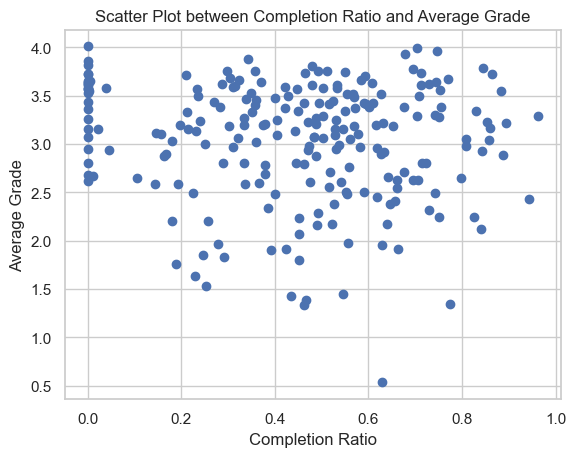

In [58]:
plt.scatter(df_grades_vs_competion['completion_ratio'], df_grades_vs_competion['avg_grade'])
plt.title('Scatter Plot between Completion Ratio and Average Grade')
plt.xlabel('Completion Ratio')
plt.ylabel('Average Grade')
plt.show()

#### There appears to be no correlation between the ratio of content that a student completes in a d2l shel and their grade values.  We already had an incling of this when we saw that a course with no content had a full range of possible grade values.

### Checking for correlation within our dataframe using pair-plots

/Users/jlo/anaconda3/envs/newenv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


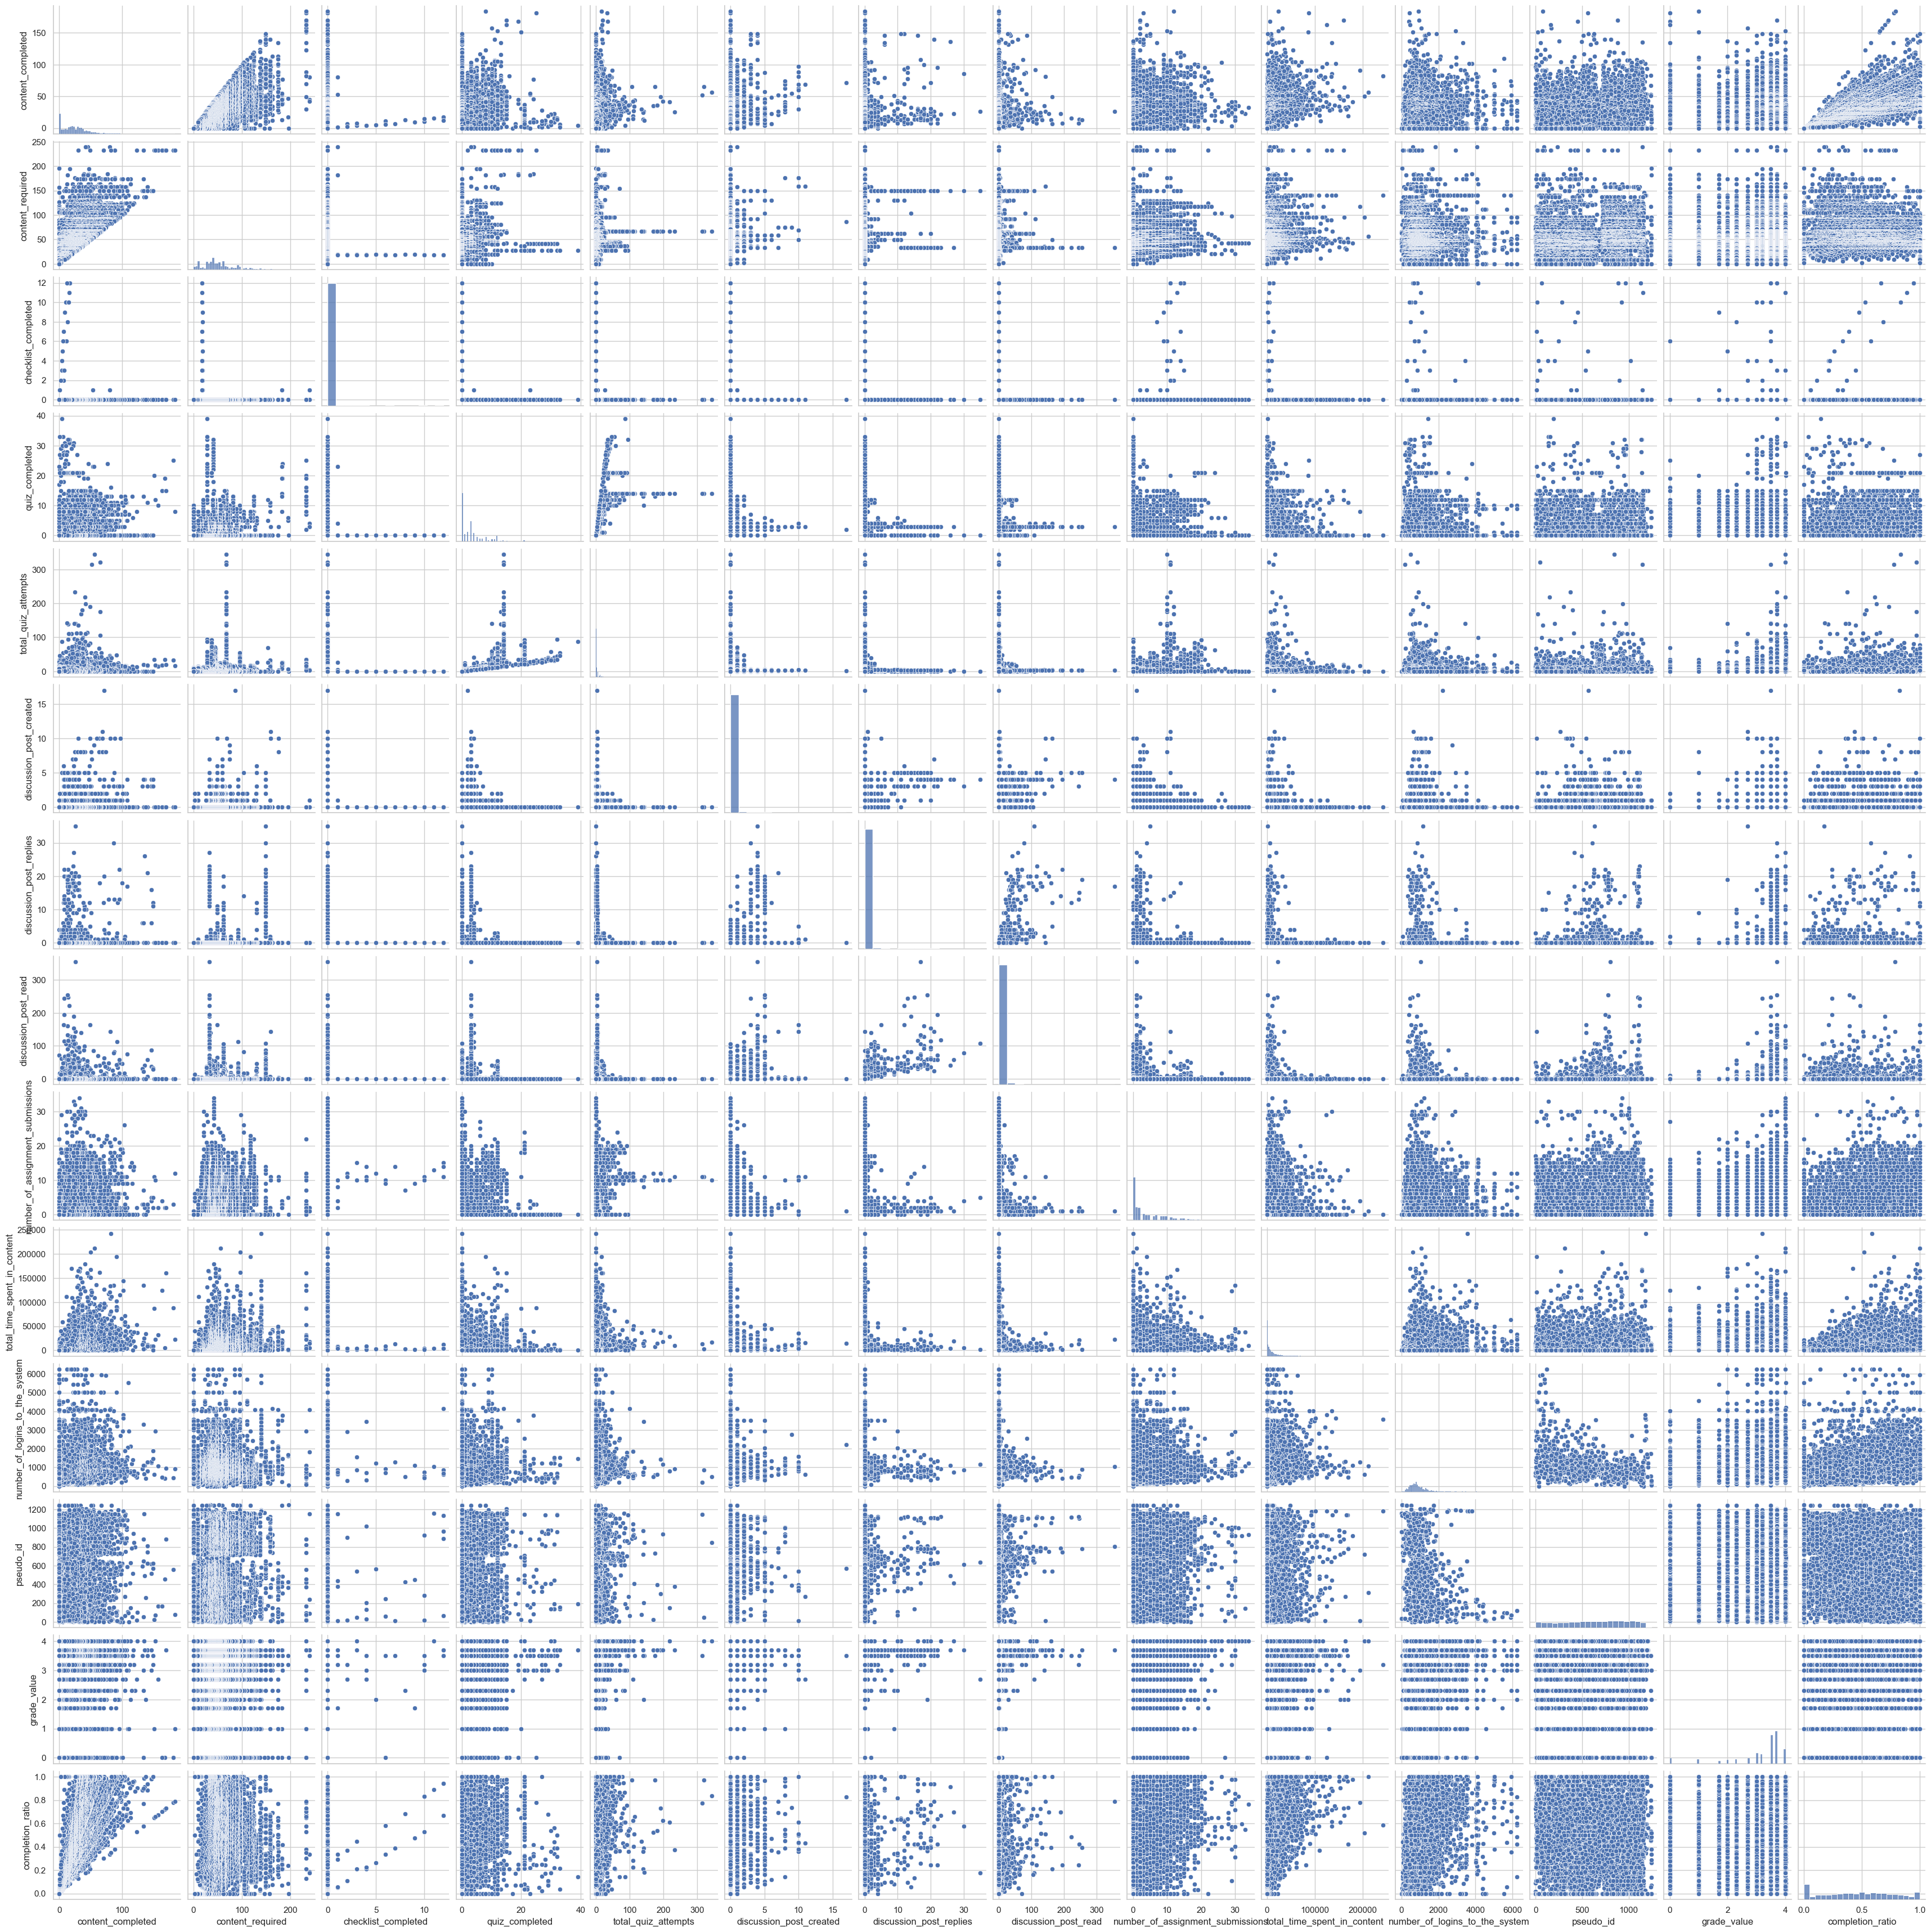

In [59]:
# Let's check the relationship between the columns in our df_d2l dataframe
sns.pairplot(df_d2l)
plt.show()

#### There appears to be some correlation between some of the features, albeit most look fairly weak.  We will, however, check for multi-colinearity between our features after we have added our engineered values.

## Checking for Multicolinearity in our features:

In [60]:
# Let's load the "cleaned_df" from the model_training notebook.  
df = pd.read_csv('data/processed_data/df_cleaned.csv')

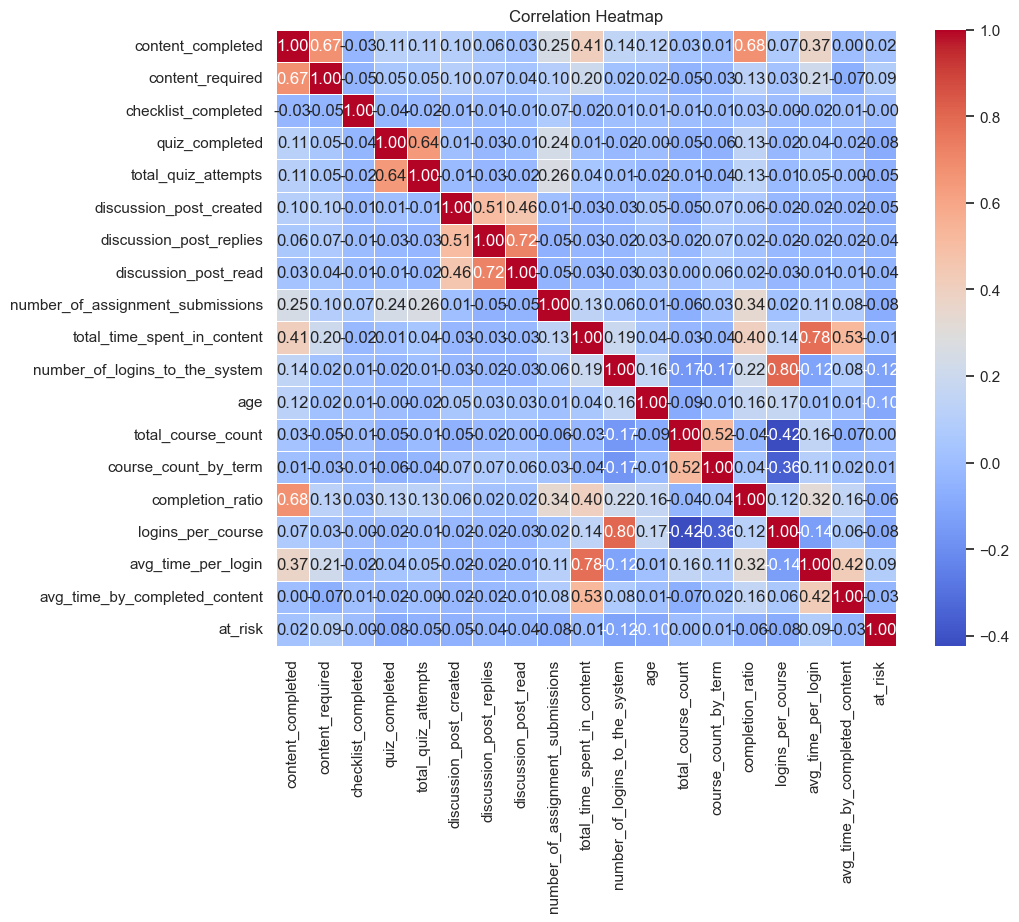

In [61]:
df_numeric = df.select_dtypes(include=[np.number])
correlation_matrix = df_numeric.corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [64]:
# Print the features with the highest correlations
threshold = 0.5

print("Highly Correlated Features:")
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        correlation_value = correlation_matrix.iloc[i, j]
        if abs(correlation_value) > threshold:
            feature1 = correlation_matrix.columns[i]
            feature2 = correlation_matrix.columns[j]
            print(f"{feature1} and {feature2}: {correlation_value}")

Highly Correlated Features:
content_required and content_completed: 0.674593143258026
total_quiz_attempts and quiz_completed: 0.6421326366356924
discussion_post_replies and discussion_post_created: 0.5070515531210408
discussion_post_read and discussion_post_replies: 0.7187430023368523
course_count_by_term and total_course_count: 0.5212816787649518
completion_ratio and content_completed: 0.6753590999938436
logins_per_course and number_of_logins_to_the_system: 0.8007633651165339
avg_time_per_login and total_time_spent_in_content: 0.7780137622111015
avg_time_by_completed_content and total_time_spent_in_content: 0.5264862368079938


### Given this information, we needed to make some adjustments to our pre-preocessing to either eliminate one of the two correlated features or engineer news ones that can replace and retain the data of both correlated features.  We've decided to:
- keep discussion_post_read, drop discussion_post_created and discusion_post_replies
- create a new variable called quiz_attempts_per_quiz, and remove both total_quiz_attempts and quiz_completed
- keep content_required along with calculated completion_ratio and avg_time_by_completed_content, but remove content_completed
- remove number_of_logins_to_the_system after all other engineered values are added since many of the engineered features uses this value.

### After making alterations to the pre-processing, we wanted to double check that we've eliminated all of our most correlated features:

In [66]:
# Let's load the "cleaned_df" from the model_training notebook.  
df_modified = pd.read_csv('data/processed_data/df_modified.csv')

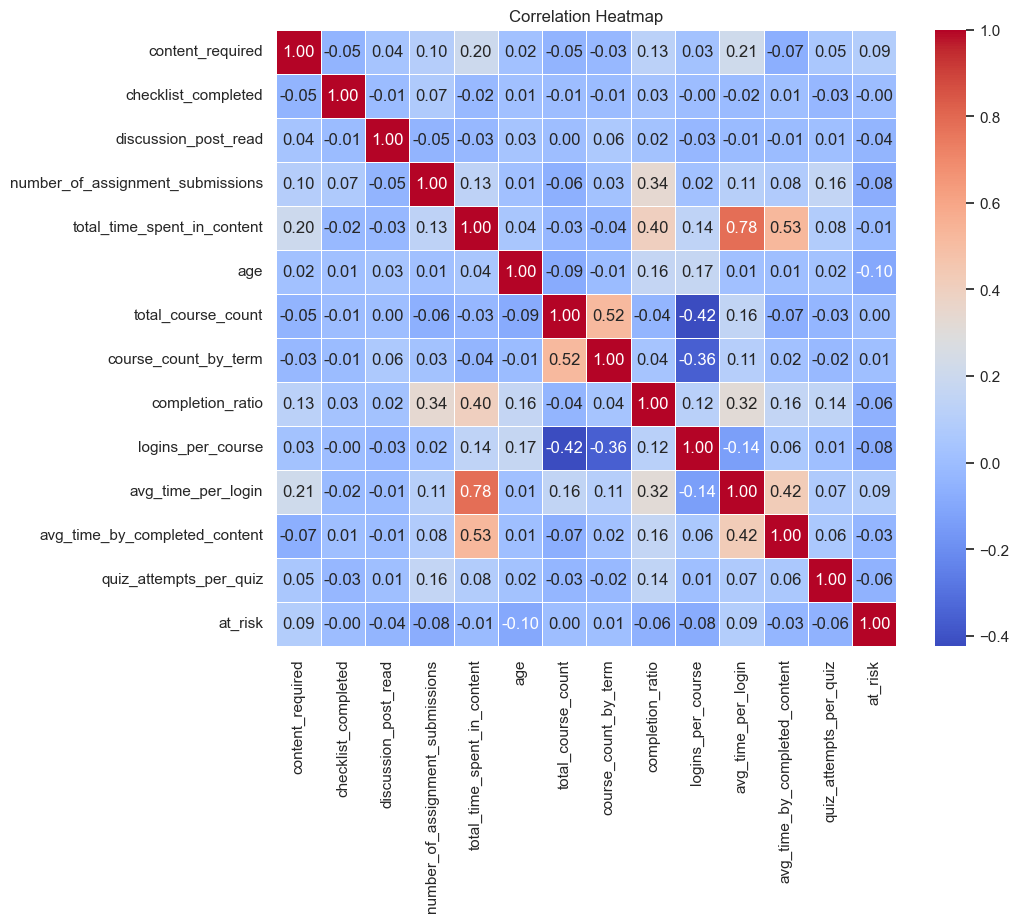

In [67]:
df_numeric = df_modified.select_dtypes(include=[np.number])
correlation_matrix = df_numeric.corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

#### We've eliminated the majority of the the highest correlated features. The couple that are left, we will leave for now and see if we can remove them later.

# Section 2: Exploring the Strengths/Weaknesses of Mulitple Classifier Models

### In this section, we will explore the dictionary of "False Negatives" created in our model_training_notebook.

#### The goal is to determine whether there are any patterns or commonalities among the False Negative entries from the multiple classifier models that were trained and tested in the "model_training_notebook".  Maybe this can lead us to come up with more engineered features or another plan to minimize the number of false negatives produced in our final model.

In [69]:
import pickle
# Load false_negatives_dict from the saved file
with open('data/processed_data/false_negatives_dict.pkl', 'rb') as file:
    false_negatives_dict = pickle.load(file)
    
false_negatives_df = pd.read_csv('data/processed_data/false_negatives_df.csv')

### Intersection of FNs

- First we'll check how many of the 9 classifiers misclassified each of the unique false negative entries

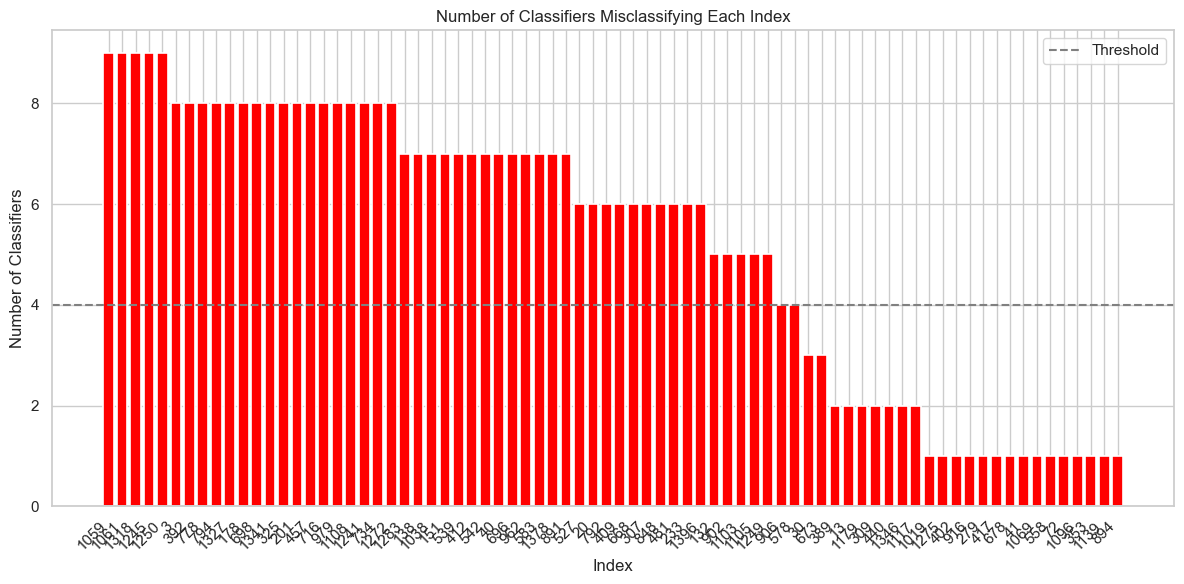

In [100]:
all_indices = [index for indices in false_negatives_dict.values() for index in indices]

# Count the occurrences of each index
index_counts = {index: all_indices.count(index) for index in set(all_indices)}

indices = list(map(int, index_counts.keys()))
counts = list(index_counts.values())

# Sort indices and counts in descending order of counts
sorted_indices, sorted_counts = zip(*sorted(zip(indices, counts), key=lambda x: x[1], reverse=True))

# Plot the bar graph with categorical data
plt.figure(figsize=(12, 6))
bars = plt.bar(list(map(str, sorted_indices)), sorted_counts, color='red', linewidth=1.2)

# Add a horizontal line at 4
plt.axhline(y=4, color='grey', linestyle='--', label='Threshold')

plt.title('Number of Classifiers Misclassifying Each Index')
plt.xlabel('Index')
plt.ylabel('Number of Classifiers')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend()  # Show legend for the horizontal line
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

- Many (~2/3) of the false negatives have the majority of the classifiers misrepresenting them (above the dotted line), however, the other 1/3 of the false negatives have less than the majority.
- Maybe we can try and find out the overlap of false negatives between the 9 classifiers, and then determine the classifiers that have the least amount of overlap.  If we can determine this, we may be able to create a voting classifier that leverages the strengths/weaknesses of some of the classifiers.

In [101]:
from itertools import combinations

# Create a list of classifiers
classifier_names = list(false_negatives_dict.keys())

# Initialize a dictionary to store the intersection counts between classifier pairs
intersection_counts = {pair: 0 for pair in combinations(classifier_names, 2)}

# Count the intersections
for pair in combinations(classifier_names, 2):
    classifier1, classifier2 = pair
    intersections = set(false_negatives_dict[classifier1]) & set(false_negatives_dict[classifier2])
    intersection_counts[pair] = len(intersections)

# Print intersection counts
for pair, count in intersection_counts.items():
    print(f"Intersection between {pair[0]} and {pair[1]}: {count}")

# Find the pair with the most and least overlap
most_overlap_pair = max(intersection_counts, key=intersection_counts.get)
least_overlap_pair = min(intersection_counts, key=intersection_counts.get)

print(f"Most overlap between {most_overlap_pair[0]} and {most_overlap_pair[1]}: {intersection_counts[most_overlap_pair]}")
print(f"Least overlap between {least_overlap_pair[0]} and {least_overlap_pair[1]}: {intersection_counts[least_overlap_pair]}")


Intersection between RandomForest and GradientBoosting: 35
Intersection between RandomForest and SVM: 48
Intersection between RandomForest and KNN: 46
Intersection between RandomForest and LogisticRegression: 46
Intersection between RandomForest and RidgeRegression: 47
Intersection between RandomForest and NaiveBayes: 7
Intersection between RandomForest and NeuralNetwork: 30
Intersection between RandomForest and XGBoost: 36
Intersection between GradientBoosting and SVM: 37
Intersection between GradientBoosting and KNN: 37
Intersection between GradientBoosting and LogisticRegression: 36
Intersection between GradientBoosting and RidgeRegression: 37
Intersection between GradientBoosting and NaiveBayes: 7
Intersection between GradientBoosting and NeuralNetwork: 27
Intersection between GradientBoosting and XGBoost: 28
Intersection between SVM and KNN: 51
Intersection between SVM and LogisticRegression: 54
Intersection between SVM and RidgeRegression: 53
Intersection between SVM and NaiveBay

- We can see that there is little overlap between Naive Bayes and all of the other classifiers since Naive Bayes only had 11 false negatives in total.  So this is not a surprise.  However, we do have the least amount of overlap between Naive Bayes and XGBoost.
- Let's find the models that have the least overall overlap with other models:

In [104]:
# Given intersection information
intersections = {
    'RandomForest': {'GradientBoosting': 35, 'SVM': 48, 'KNN': 46, 'LogisticRegression': 46, 'RidgeRegression': 47, 'NaiveBayes': 7, 'NeuralNetwork': 30, 'XGBoost': 36},
    'GradientBoosting': {'SVM': 37, 'KNN': 37, 'LogisticRegression': 36, 'RidgeRegression': 37, 'NaiveBayes': 7, 'NeuralNetwork': 27, 'XGBoost': 28},
    'SVM': {'KNN': 51, 'LogisticRegression': 54, 'RidgeRegression': 53, 'NaiveBayes': 11, 'NeuralNetwork': 34, 'XGBoost': 36},
    'KNN': {'LogisticRegression': 48, 'RidgeRegression': 49, 'NaiveBayes': 8, 'NeuralNetwork': 32, 'XGBoost': 35},
    'LogisticRegression': {'RidgeRegression': 49, 'NaiveBayes': 9, 'NeuralNetwork': 32, 'XGBoost': 35},
    'RidgeRegression': {'NaiveBayes': 9, 'NeuralNetwork': 33, 'XGBoost': 35},
    'NaiveBayes': {'NeuralNetwork': 10, 'XGBoost': 6},
    'NeuralNetwork': {'XGBoost': 21}
}

# Sum the intersections for each model
overlap_sums = defaultdict(int)

for model, intersections_with_other_models in intersections.items():
    for other_model, count in intersections_with_other_models.items():
        overlap_sums[model] += count

# Find models with the least amount of overlap
best_models = sorted(overlap_sums.items(), key=lambda x: x[1])[:5]

print("Models with the least amount of overlap:")
for model, overlap_sum in best_models:
    print(f"{model}: {overlap_sum}")

Models with the least amount of overlap:
NaiveBayes: 16
NeuralNetwork: 21
RidgeRegression: 77
LogisticRegression: 125
KNN: 172


- we can work with this to determine which classifiers to combine into a voting classifier.

# Section 3: Exploring Feature Importance
Now that we've trained, tested, and tuned our voting classifier model, let's explore the features that are most important. Since our voting classifier is not equipped with shap analysis options, we'll use out tuned XGBoost model from the hyperparameter_tuning notebook.

In [106]:
df = pd.read_csv('data/processed_data/df_clean.csv')
X = df.drop('at_risk', axis=1)
y = df.at_risk

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
numeric_features = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
preprocessor = build_preprocessor(numeric_features, categorical_features)

In [120]:
xgb_model = build_full_pipeline(preprocessor, XGBClassifier(learning_rate=0.3, 
                                                            max_depth=3, 
                                                            n_estimators=100, 
                                                            scale_pos_weight=9))

xgb_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       inverse_func=<ufunc 'expm1'>))]),
                                                  ['content_required',
                                                   'checklist_completed',
                                                   'discussion_post_read',
                                                   'number_of_assignment_submissions',
                                                   'total_time_sp...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [121]:
# Extract the fitted model from the pipeline
fitted_xgb_model = xgb_model.named_steps['model']

# Transform the test data using the preprocessor
X_test_transformed = preprocessor.transform(X_test)

# Assume you have your model trained
explainer_xgb = shap.Explainer(fitted_xgb_model)

shap_values_xgb = explainer_xgb.shap_values(X_test_transformed)

In [122]:
# Get the feature names after transformation for numeric features
numeric_feature_names = numeric_features

# Get the feature names after transformation for categorical features
categorical_feature_names = preprocessor.transformers_[1][1].get_feature_names_out(
    input_features=categorical_features  # Assuming categorical_features contains the original feature names
)

# Concatenate the feature names for numeric and categorical features
original_feature_names = np.concatenate([numeric_feature_names, categorical_feature_names])


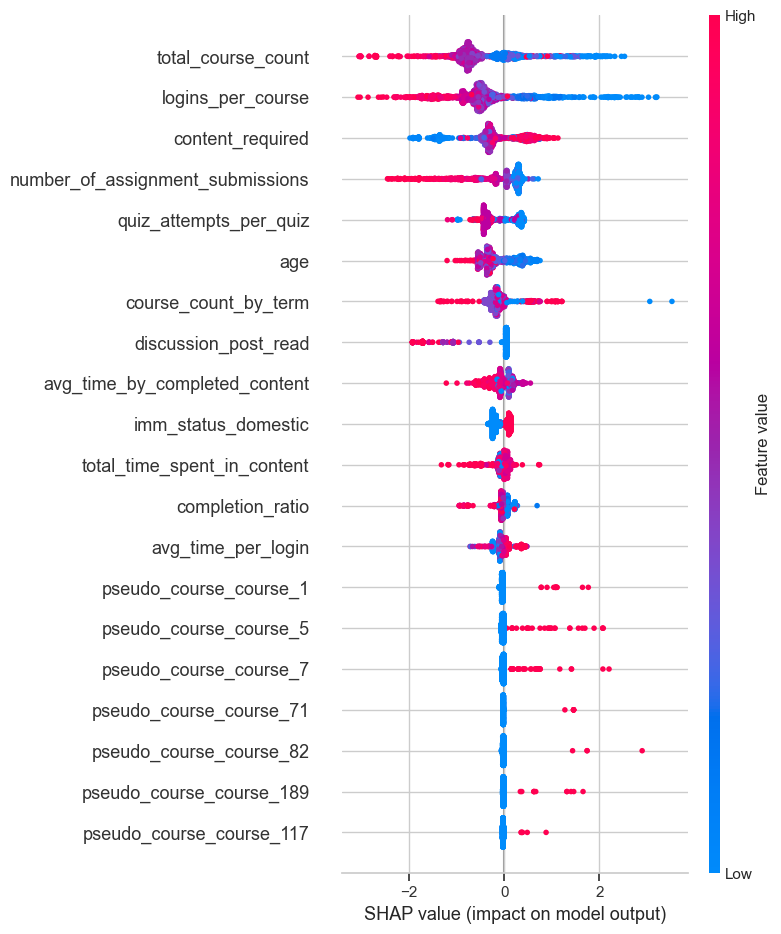

In [126]:
shap.initjs()

# Summary Plot
shap.summary_plot(shap_values_xgb, X_test_transformed, feature_names=original_feature_names)

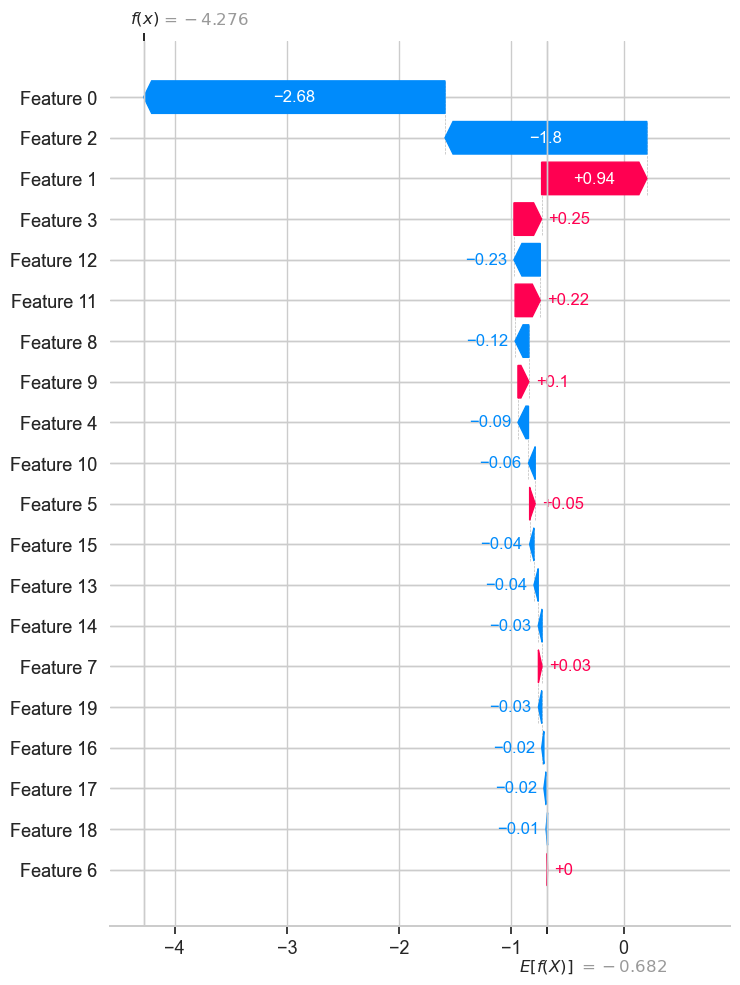

['total_course_count', 'logins_per_course', 'content_required', 'number_of_assignment_submissions', 'quiz_attempts_per_quiz', 'age', 'course_count_by_term', 'discussion_post_read', 'avg_time_by_completed_content', 'imm_status_domestic', 'total_time_spent_in_content', 'completion_ratio', 'avg_time_per_login', 'pseudo_course_course_1', 'pseudo_course_course_5', 'pseudo_course_course_7', 'pseudo_course_course_71', 'pseudo_course_course_82', 'pseudo_course_course_189', 'pseudo_course_course_117']


In [124]:
# Assuming shap_values is your SHAP values matrix, and original_feature_names is a list of feature names
top_features_indices = np.abs(shap_values_xgb).mean(0).argsort()[::-1][:20]  # Get the indices of the top 20 features

# Select the SHAP values and feature names for the top features
top_shap_values = shap_values_xgb[:, top_features_indices]
top_feature_names = [original_feature_names[i] for i in top_features_indices]

# Create a waterfall plot for the top 20 features
shap.waterfall_plot(shap.Explanation(values=top_shap_values[0, :], base_values=explainer_xgb.expected_value), max_display=20)

print(top_feature_names)

### Results:
These are interesting results because total_course_count represents the total number of courses the student has attempted at the moment the data was downloaded from D2L.  This number has nothing directly to do with the course grade itself, but instead, how long they've been a student.  Given this information, however, it is easy to see that a student who has been at the college longer would have more attempted courses, and simultaneously, less likely to fail a course.  

We also see that logins_per_course is the next important feature, which is engineered based on the total number oflogins the student has had into the system and divided by the number of courses they've completed. Given how much predicitive power is given to this feature, using it to predict whether a new student is at risk in any given course is not necessarily going to work.  That is to say, a new student who is maybe only 3 weeks into the semester in their first year will not have very many logins to the system and consequently, their logins_per_course value will be quite low, so the model may potentially predict too many new students as at-risk that are not.

When implementing this model, it will be important to alter the student data to be more reflective of end-of-term results than using them as is.

- These alterations to mid-term data can be found in the pre_predict_processing.py file.

# Section 4: Testing Our Model on Unseen Data

Let's test our model with different data, from other semesters.  These semesters are all during the pandemic season, so it'll be interesting to see how our model performs on it.

In [129]:
excel_file = pd.ExcelFile('data/raw_data/D2lData2.xlsx')

# Reading each sheet into a DataFrame
df_d2l = pd.read_excel(excel_file, 'd2l')
df_demo = pd.read_excel(excel_file, 'demographics')
df_grades = pd.read_excel(excel_file, 'grades')

In [132]:
df_test = df_construct(df_d2l, df_demo, df_grades)

In [133]:
X_test = df_test.drop('at_risk', axis=1)
y_test = df_test.at_risk

In [146]:
import joblib
# Load saved models and best parameters
voting_classifier_best_model = joblib.load('models/voting_classifier_best_model.pkl')

In [147]:
y_pred = voting_classifier_best_model.predict(X_test)

In [148]:
# Evaluate Performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Accuracy: {accuracy}\n")
print(f"ROC_AUC: {roc_auc}\n")
print("Classification Report:\n", classification_rep)
print('Confusion Matrix:\n', conf_matrix)

Accuracy: 0.8176702307259426

ROC_AUC: 0.6550512005649718

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.86      0.89      1600
           1       0.26      0.45      0.33       177

    accuracy                           0.82      1777
   macro avg       0.60      0.66      0.61      1777
weighted avg       0.87      0.82      0.84      1777

Confusion Matrix:
 [[1373  227]
 [  97   80]]


- We can see here that the model performance does struggle with unseen/new data.  With 45% recall on the under-represented group and an ROC_AUC score of ~0.66, the model is not performing as well as hoped.
- This new data, however, is from terms during covid lockdowns and in a season where most classes were online.  I believe this is a strong contributor as to why we are not seeing as good results from the model, which was trained with post-pandemic data where students were back in-person.
- We could be observing that our model is overfit to the training data as well.  We would have a better idea of this if we had more data post-pandemic.  Once this data is collected, we can put the model back to the test to find out if this is the case.